In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CTG data full visualization

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import keras
import numpy as np
from itertools import chain
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
months = [8928,8928+8352,8928+8352+8928,8928+8352+8928+8640,8928+8352+8928+8640+8928,8928+8352+8928+8640+8928+8640,8928+8352+8928+8640+8928+8640+8928,8928+8352+8928+8640+8928+8640+8928+8928,8928+8352+8928+8640+8928+8640+8928+8928+8640,8928+8352+8928+8640+8928+8640+8928+8928+8640+8928,8928+8352+8928+8640+8928+8640+8928+8928+8640+8928+8640,8928+8352+8928+8640+8928+8640+8928+8928+8640+8928+8640+8928]

In [ ]:
day_count = 288
day_hour = []
for i in range(31):
  day_hour.append(day_count)
  day_count += 288

In [ ]:
day = [*range(1, 864, 1)]

In [ ]:
dataframe = pandas.read_csv("/content/drive/MyDrive/Tide work/CTG/dataset/CTG_2020.csv",
                            header=None, delimiter = "\t", engine="python")


dataframe = dataframe.drop(dataframe.index[0])
dataframe = dataframe.reset_index(drop=True)

In [ ]:
start_range_data = 0
end_range_data = 0

for x in range(len(dataframe)):
  if((dataframe[0][x] == '1/1/2020') & (dataframe[1][x] == '0:00')):
    start_range_data = x
  if((dataframe[0][x] == '12/31/2020') & (dataframe[1][x] == '23:55')):
    end_range_data = x


dataframe = dataframe.iloc[start_range_data:(end_range_data+1)]

In [ ]:
dataframe = dataframe.drop(columns=[0,1])
dataframe = dataframe.T
dataframe = np.asarray(dataframe)
dataframe = dataframe.astype(np.float)

In [ ]:
dataframe = np.resize(dataframe, dataframe.shape[1])

In [ ]:
dataframe.shape

(8305,)

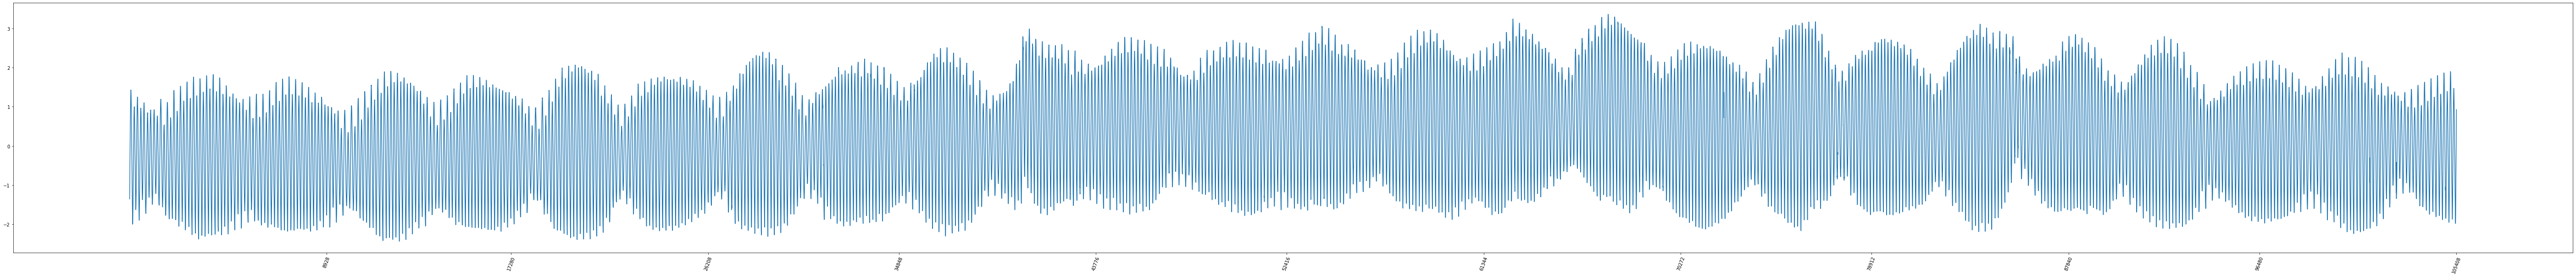

In [ ]:
#fig, ax = plt.subplots(figsize=(100,10))
#ax.set_xticks(day)
plt.figure(figsize=(100,10))
plt.xticks(months, rotation=70)
plt.plot(dataframe)
plt.show()

# see 1 days & predict & forecast next 15 & 30 days [Train 1 month]

## imports

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import keras
import numpy as np
from itertools import chain
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

## data preparation

In [ ]:
dataframe = pandas.read_csv("/content/drive/MyDrive/Tide work/CTG/dataset/CTG_2020.csv",
                            header=None, delimiter = "\t", engine="python")

dataframe = dataframe.drop(dataframe.index[0])
dataframe = dataframe.reset_index(drop=True)

In [ ]:
see_days = 1

## train data

In [ ]:
start_range_train = 0
end_range_train = 0

for x in range(len(dataframe)):
  if((dataframe[0][x] == '3/1/2020') & (dataframe[1][x] == '0:00')):
    start_range_train = x
  if((dataframe[0][x] == '3/31/2020') & (dataframe[1][x] == '23:55')):
    end_range_train = x


train_data = dataframe.iloc[start_range_train:(end_range_train+1)]
train_data = train_data.drop(columns=[0,1])

# train_data = train_data.values
# train_data = train_data.astype('float32')

In [ ]:
train_data = train_data.T
train_data.shape

(1, 8928)

In [ ]:
train_data = np.asarray(train_data)
train_data = train_data.tolist()
train_data = list(chain.from_iterable(train_data))

## test data

In [ ]:
start_range_test = 0
end_range_test = 0

for x in range(len(dataframe)):
  if((dataframe[0][x] == '3/31/2020') & (dataframe[1][x] == '0:00')):
    start_range_test = x
  if((dataframe[0][x] == '4/30/2020') & (dataframe[1][x] == '23:55')):
    end_range_test = x


test_data = dataframe.iloc[start_range_test:(end_range_test+1)]
test_data = test_data.drop(columns=[0,1])

# test_data = test_data.values
# test_data = test_data.astype('float32')

In [ ]:
test_data = test_data.T
test_data.shape

(1, 8928)

In [ ]:
test_data = np.asarray(test_data)
test_data = test_data.tolist()
test_data = list(chain.from_iterable(test_data))

## X, y for train & test

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  for i in range(0,(len(dataset)-look_back*see_days),look_back):
    a = dataset[i:(i + look_back*see_days)]
    dataX.append(a)
    b = dataset[(i + look_back*see_days):(i + look_back*(see_days+1))]
    dataY.append(b)
  return dataX, dataY

In [ ]:
# reshape into X=t and Y=t+1
look_back = 288
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [ ]:
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)

testX = np.asarray(testX)
testY = np.asarray(testY)

In [ ]:
trainX = trainX.astype(np.float)
trainY = trainY.astype(np.float)

testX = testX.astype(np.float)
testY = testY.astype(np.float)

In [ ]:
# reshape input to be [samples, time steps, features]
# train_X = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# test_X = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

train_X = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test_X = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
train_X.shape

(30, 288, 1)

## model train

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(512, input_shape=(look_back*see_days, 1)))
model.add(Dense(look_back))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, trainY, epochs=100, batch_size=1, verbose=2) #, callbacks=[es]

Epoch 1/100
30/30 - 33s - loss: 1.3926
Epoch 2/100
30/30 - 1s - loss: 1.1438
Epoch 3/100
30/30 - 1s - loss: 1.0637
Epoch 4/100
30/30 - 1s - loss: 0.7272
Epoch 5/100
30/30 - 1s - loss: 0.5601
Epoch 6/100
30/30 - 1s - loss: 0.4243
Epoch 7/100
30/30 - 1s - loss: 0.3135
Epoch 8/100
30/30 - 1s - loss: 0.4013
Epoch 9/100
30/30 - 1s - loss: 0.1252
Epoch 10/100
30/30 - 1s - loss: 0.2904
Epoch 11/100
30/30 - 1s - loss: 0.0856
Epoch 12/100
30/30 - 1s - loss: 0.0530
Epoch 13/100
30/30 - 1s - loss: 0.0718
Epoch 14/100
30/30 - 1s - loss: 0.0560
Epoch 15/100
30/30 - 1s - loss: 0.0858
Epoch 16/100
30/30 - 1s - loss: 0.0556
Epoch 17/100
30/30 - 1s - loss: 0.0469
Epoch 18/100
30/30 - 1s - loss: 0.0281
Epoch 19/100
30/30 - 1s - loss: 0.0346
Epoch 20/100
30/30 - 1s - loss: 0.0822
Epoch 21/100
30/30 - 1s - loss: 0.1613
Epoch 22/100
30/30 - 1s - loss: 0.0433
Epoch 23/100
30/30 - 1s - loss: 0.0453
Epoch 24/100
30/30 - 1s - loss: 0.0360
Epoch 25/100
30/30 - 1s - loss: 0.0679
Epoch 26/100
30/30 - 1s - loss: 0

## make prediction and save model

In [ ]:
# make predictions
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

Train Score: 0.06909 RMSE
Test Score: 0.08878 RMSE


In [ ]:
model.save('/content/drive/MyDrive/Tide work/CTG/lb_1_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')

In [ ]:
# from keras.models import load_model
# model1 = load_model('/content/drive/MyDrive/Tide work/CTG/lb_1_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')
# trainPredict = model1.predict(train_X)
# testPredict = model1.predict(test_X)

# trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

## train & test predict + plot

In [ ]:
trainY_c = np.resize(trainY,(len(train_data)-look_back*see_days,1))
trainPredict_c = np.resize(trainPredict,(len(train_data)-look_back*see_days,1))
testY_c = np.resize(testY,(len(test_data)-look_back*see_days,1))
testPredict_c = np.resize(testPredict,(len(test_data)-look_back*see_days,1))

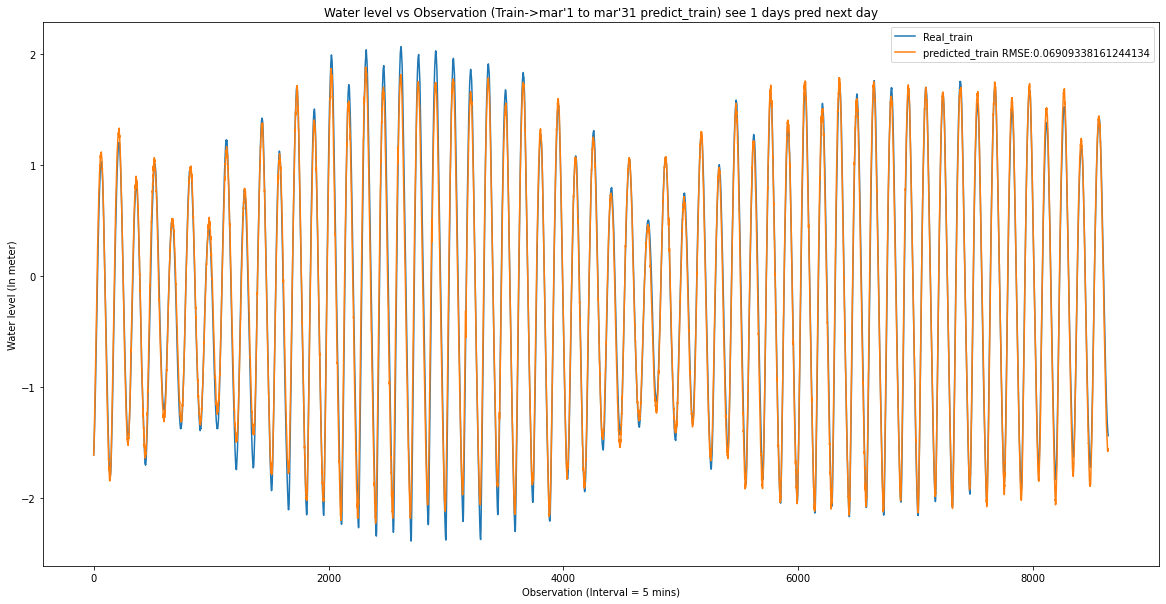

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(trainPredict_c)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[0:len(trainPredict_c), :] = trainPredict_c

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(trainY_c, label = "Real_train")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(trainPredictPlot, label = "predicted_train RMSE:"+str(trainScore))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 predict_train) see "+str(see_days)+" days pred next day")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_1_tr_1mon/1 see "+str(see_days)+" days pred next day (train).png")

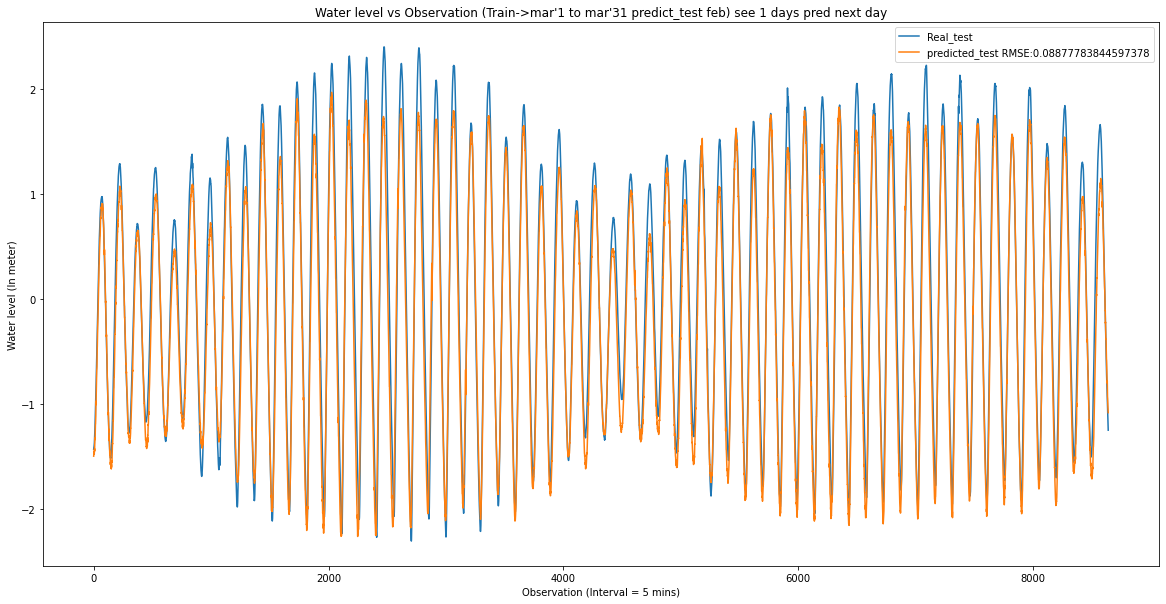

In [ ]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testPredict_c)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[0:len(testPredict_c), :] = testPredict_c
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(testY_c, label = "Real_test")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(testPredictPlot, label = "predicted_test RMSE:"+str(testScore))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 predict_test feb) see "+str(see_days)+" days pred next day")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_1_tr_1mon/1 see "+str(see_days)+" days pred next day (test).png")

## forecast 15 days

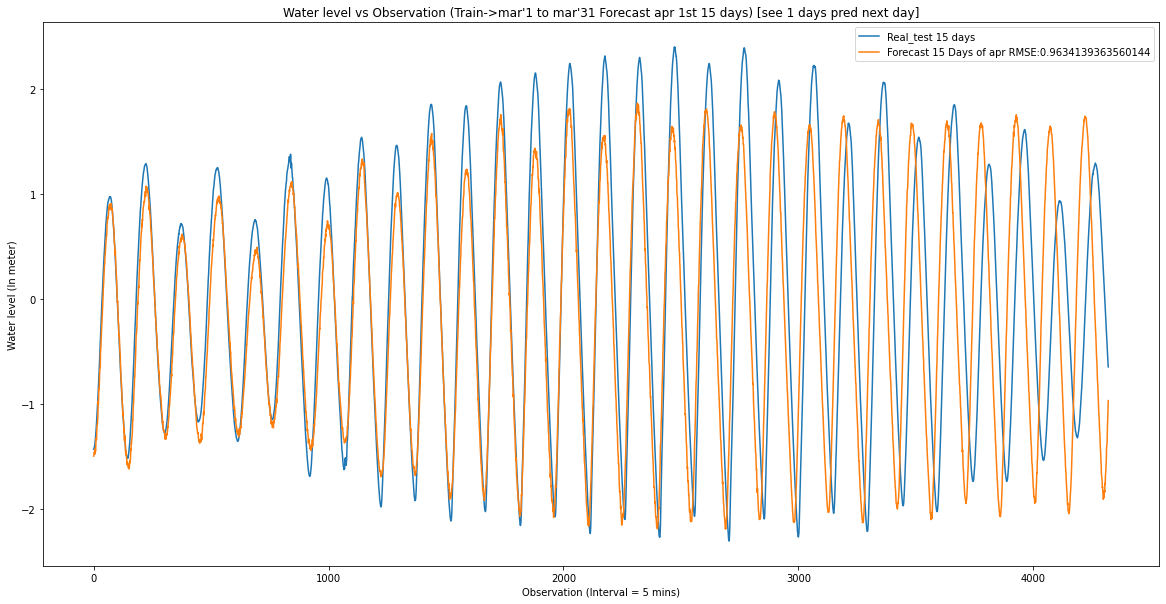

In [ ]:
#For 15 days 
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Tide work/CTG/lb_1_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')
forecast_15days=[]
#test = train_X[-1]
test = test_X[0]
a = test_X[0].tolist()
shift = 0

for i in range(15):
  train = a[0+shift: (look_back*see_days)+shift]
  train = np.asarray(train)
  train = numpy.reshape(train, (1, trainX.shape[1], 1))
  test = model1.predict(train)
  var1 = test[0]
  var1 = var1.tolist()
  var2 = [[i] for i in var1]
  test = numpy.reshape(test, (trainY.shape[1]))
  forecast_15days.append(test)
  # print(a)
  a = a + var2
  # print(a)
  shift = shift + look_back

forecast_15days = numpy.array(forecast_15days)
forcast15Score = math.sqrt(mean_squared_error(testY[:15,0], forecast_15days[:,0]))

#testY_c = np.resize(testY,(len(dataset_test[:2016]),1))
testPredict_c = np.resize(forecast_15days,(look_back*15,1))

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testPredict_c)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[0:len(testPredict_c), :] = testPredict_c

fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(dataset_test[:2016], label = "Real_test 15 days ")
ax.plot(testY_c[:4320], label = "Real_test 15 days ")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(testPredictPlot, label = "Forecast 15 Days of apr RMSE:"+str(forcast15Score))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 Forecast apr 1st 15 days) [see "+str(see_days)+" days pred next day]")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_1_tr_1mon/15days/15 Water level vs Observation (Train - mar'1 to mar'31 Forecast apr 1st 15 days) see "+str(see_days)+" days pred next day.png")

## forecast 30 days

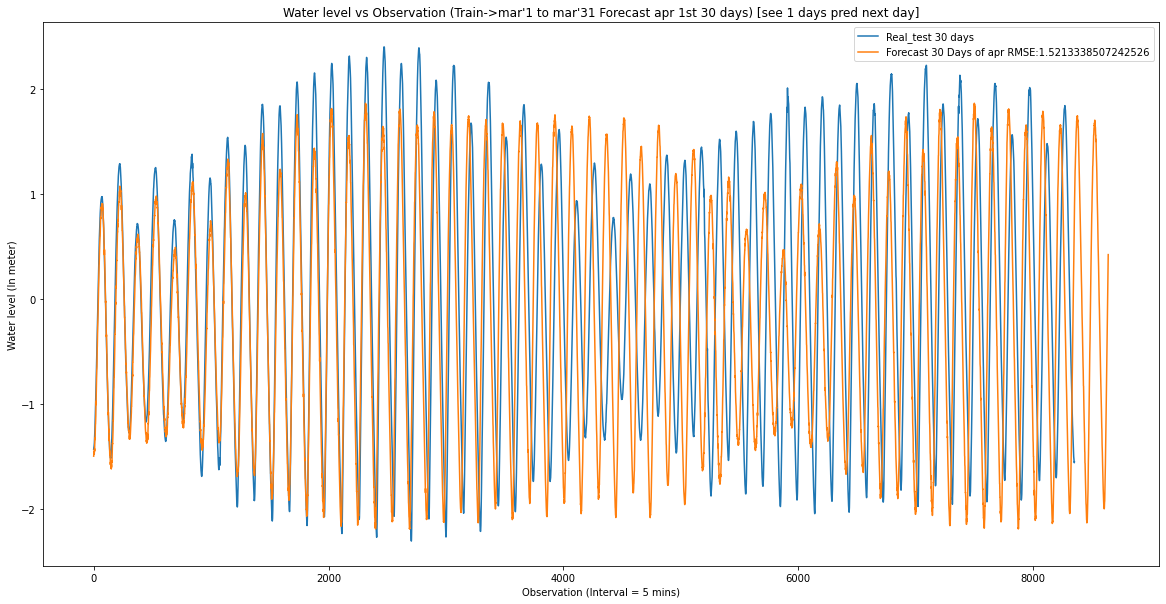

In [ ]:
#For 30 days 
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Tide work/CTG/lb_1_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')
forecast_30days=[]
#test = train_X[-1]
test = test_X[0]
a = test_X[0].tolist()
shift = 0

for i in range(30):
  train = a[0+shift: (look_back*see_days)+shift]
  train = np.asarray(train)
  train = numpy.reshape(train, (1, trainX.shape[1], 1))
  test = model1.predict(train)
  var1 = test[0]
  var1 = var1.tolist()
  var2 = [[i] for i in var1]
  test = numpy.reshape(test, (trainY.shape[1]))
  forecast_30days.append(test)
  # print(a)
  a = a + var2
  # print(a)
  shift = shift + look_back

forecast_30days = numpy.array(forecast_30days)
forcast30Score = math.sqrt(mean_squared_error(testY[:30,0], forecast_30days[:,0]))

#testY_c = np.resize(testY,(len(dataset_test[:2016]),1))
testPredict_c = np.resize(forecast_30days,(look_back*30,1))

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testPredict_c)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[0:len(testPredict_c), :] = testPredict_c

fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(dataset_test[:2016], label = "Real_test 30 days ")
ax.plot(testY_c[:8352], label = "Real_test 30 days ")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(testPredictPlot, label = "Forecast 30 Days of apr RMSE:"+str(forcast30Score))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 Forecast apr 1st 30 days) [see "+str(see_days)+" days pred next day]")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_1_tr_1mon/30days/30 Water level vs Observation (Train - mar'1 to mar'31 Forecast apr 1st 30 days) see "+str(see_days)+" days pred next day.png")

# see 14 days & predict & forecast next 15 days [Train 1 month]

## imports

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import keras
import numpy as np
from itertools import chain
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

## data preparation

In [ ]:
dataframe = pandas.read_csv("/content/drive/MyDrive/Tide work/CTG/dataset/CTG_2020.csv",
                            header=None, delimiter = "\t", engine="python")

dataframe = dataframe.drop(dataframe.index[0])
dataframe = dataframe.reset_index(drop=True)

In [ ]:
see_days = 14

## train data

In [ ]:
start_range_train = 0
end_range_train = 0

for x in range(len(dataframe)):
  if((dataframe[0][x] == '3/1/2020') & (dataframe[1][x] == '0:00')):
    start_range_train = x
  if((dataframe[0][x] == '3/31/2020') & (dataframe[1][x] == '23:55')):
    end_range_train = x


train_data = dataframe.iloc[start_range_train:(end_range_train+1)]
train_data = train_data.drop(columns=[0,1])

# train_data = train_data.values
# train_data = train_data.astype('float32')

In [ ]:
train_data = train_data.T
train_data.shape

(1, 8928)

In [ ]:
train_data = np.asarray(train_data)
train_data = train_data.tolist()
train_data = list(chain.from_iterable(train_data))

## test data

In [ ]:
start_range_test = 0
end_range_test = 0

for x in range(len(dataframe)):
  if((dataframe[0][x] == '3/18/2020') & (dataframe[1][x] == '0:00')):
    start_range_test = x
  if((dataframe[0][x] == '4/30/2020') & (dataframe[1][x] == '23:55')):
    end_range_test = x


test_data = dataframe.iloc[start_range_test:(end_range_test+1)]
test_data = test_data.drop(columns=[0,1])

# test_data = test_data.values
# test_data = test_data.astype('float32')

In [ ]:
test_data = test_data.T
test_data.shape

(1, 12672)

In [ ]:
test_data = np.asarray(test_data)
test_data = test_data.tolist()
test_data = list(chain.from_iterable(test_data))

## X, y for train & test

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  for i in range(0,(len(dataset)-look_back*see_days),look_back):
    a = dataset[i:(i + look_back*see_days)]
    dataX.append(a)
    b = dataset[(i + look_back*see_days):(i + look_back*(see_days+1))]
    dataY.append(b)
  return dataX, dataY

In [ ]:
# reshape into X=t and Y=t+1
look_back = 288
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [ ]:
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)

testX = np.asarray(testX)
testY = np.asarray(testY)

In [ ]:
trainX = trainX.astype(np.float)
trainY = trainY.astype(np.float)

testX = testX.astype(np.float)
testY = testY.astype(np.float)

In [ ]:
# reshape input to be [samples, time steps, features]
# train_X = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# test_X = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

train_X = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test_X = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
train_X.shape

(17, 4032, 1)

## model train

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(512, input_shape=(look_back*see_days, 1)))
model.add(Dense(look_back))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, trainY, epochs=100, batch_size=1, verbose=2) #, callbacks=[es]

Epoch 1/100
17/17 - 5s - loss: 1.4665
Epoch 2/100
17/17 - 4s - loss: 1.1836
Epoch 3/100
17/17 - 4s - loss: 1.1380
Epoch 4/100
17/17 - 4s - loss: 1.0663
Epoch 5/100
17/17 - 4s - loss: 1.0508
Epoch 6/100
17/17 - 4s - loss: 1.3608
Epoch 7/100
17/17 - 4s - loss: 1.0858
Epoch 8/100
17/17 - 4s - loss: 1.0346
Epoch 9/100
17/17 - 4s - loss: 0.9713
Epoch 10/100
17/17 - 4s - loss: 0.8672
Epoch 11/100
17/17 - 4s - loss: 0.7064
Epoch 12/100
17/17 - 4s - loss: 0.6769
Epoch 13/100
17/17 - 4s - loss: 0.6642
Epoch 14/100
17/17 - 4s - loss: 0.6451
Epoch 15/100
17/17 - 4s - loss: 0.6432
Epoch 16/100
17/17 - 4s - loss: 0.6250
Epoch 17/100
17/17 - 4s - loss: 0.6130
Epoch 18/100
17/17 - 4s - loss: 0.5156
Epoch 19/100
17/17 - 4s - loss: 0.4743
Epoch 20/100
17/17 - 4s - loss: 0.5614
Epoch 21/100
17/17 - 4s - loss: 0.6367
Epoch 22/100
17/17 - 4s - loss: 0.6113
Epoch 23/100
17/17 - 4s - loss: 0.6913
Epoch 24/100
17/17 - 4s - loss: 0.6610
Epoch 25/100
17/17 - 4s - loss: 0.5988
Epoch 26/100
17/17 - 4s - loss: 0.

## make prediction and save model

In [ ]:
# make predictions
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

Train Score: 0.34864 RMSE
Test Score: 0.51194 RMSE


In [ ]:
model.save('/content/drive/MyDrive/Tide work/CTG/lb_14_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')

In [ ]:
# from keras.models import load_model
# model1 = load_model('/content/drive/MyDrive/Tide work/CTG/lb_14_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')
# trainPredict = model1.predict(train_X)
# testPredict = model1.predict(test_X)

# trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

## train & test predict + plot

In [ ]:
trainY_c = np.resize(trainY,(len(train_data)-look_back*see_days,1))
trainPredict_c = np.resize(trainPredict,(len(train_data)-look_back*see_days,1))
testY_c = np.resize(testY,(len(test_data)-look_back*see_days,1))
testPredict_c = np.resize(testPredict,(len(test_data)-look_back*see_days,1))

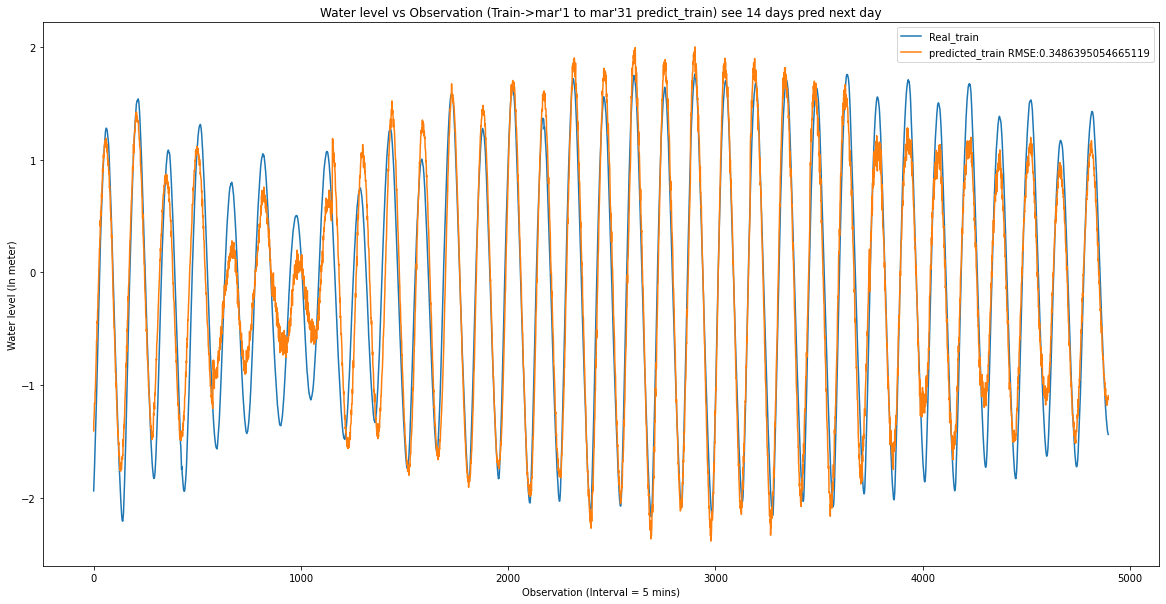

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(trainPredict_c)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[0:len(trainPredict_c), :] = trainPredict_c

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(trainY_c, label = "Real_train")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(trainPredictPlot, label = "predicted_train RMSE:"+str(trainScore))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 predict_train) see "+str(see_days)+" days pred next day")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_14_tr_1mon/1 see "+str(see_days)+" days pred next day (train).png")

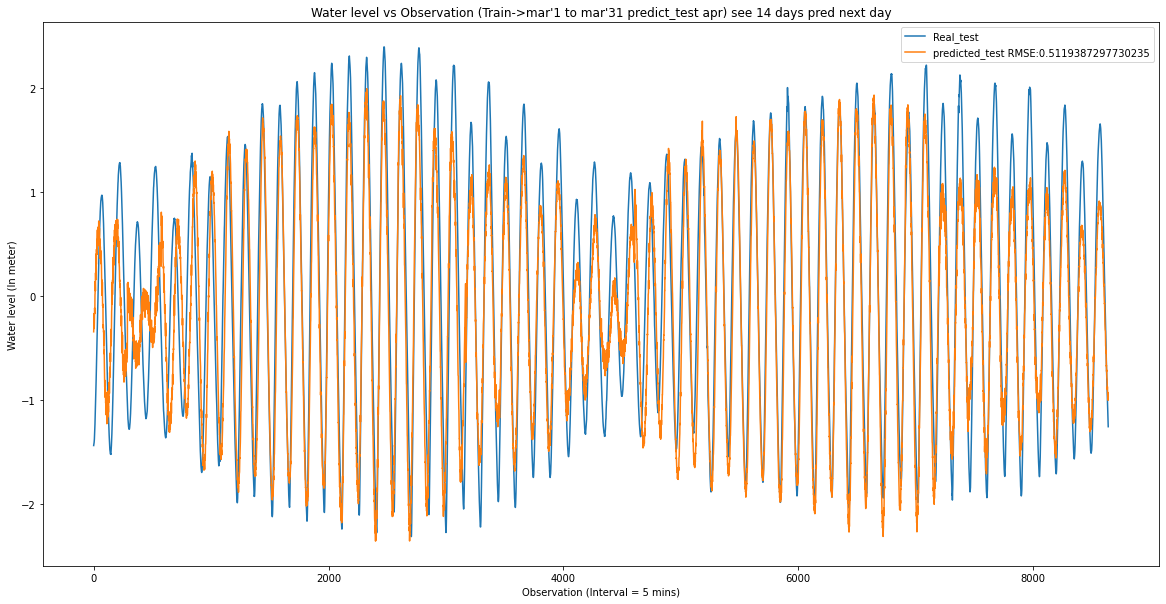

In [ ]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testPredict_c)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[0:len(testPredict_c), :] = testPredict_c
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(testY_c, label = "Real_test")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(testPredictPlot, label = "predicted_test RMSE:"+str(testScore))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 predict_test apr) see "+str(see_days)+" days pred next day")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_14_tr_1mon/1 see "+str(see_days)+" days pred next day (test).png")

## forecast 15 days

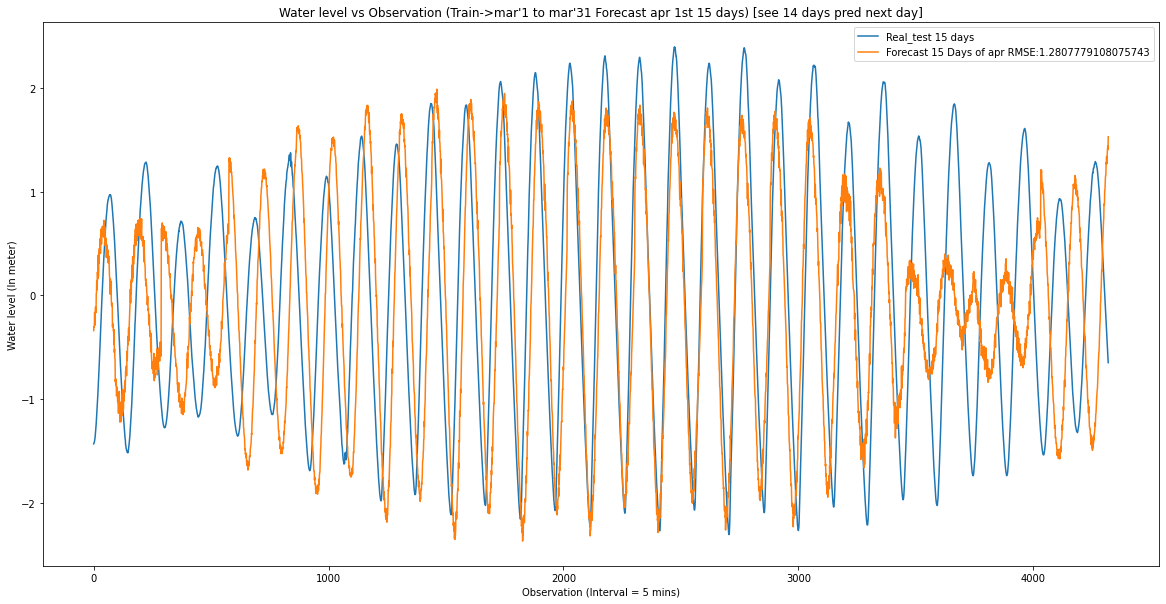

In [ ]:
#For 15 days 
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Tide work/CTG/lb_14_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')
forecast_15days=[]
#test = train_X[-1]
test = test_X[0]
a = test_X[0].tolist()
shift = 0

for i in range(15):
  train = a[0+shift: (look_back*see_days)+shift]
  train = np.asarray(train)
  train = numpy.reshape(train, (1, trainX.shape[1], 1))
  test = model1.predict(train)
  var1 = test[0]
  var1 = var1.tolist()
  var2 = [[i] for i in var1]
  test = numpy.reshape(test, (trainY.shape[1]))
  forecast_15days.append(test)
  # print(a)
  a = a + var2
  # print(a)
  shift = shift + look_back

forecast_15days = numpy.array(forecast_15days)
forcast15Score = math.sqrt(mean_squared_error(testY[:15,0], forecast_15days[:,0]))

#testY_c = np.resize(testY,(len(dataset_test[:2016]),1))
testPredict_c = np.resize(forecast_15days,(look_back*15,1))

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testPredict_c)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[0:len(testPredict_c), :] = testPredict_c

fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(dataset_test[:2016], label = "Real_test 15 days ")
ax.plot(testY_c[:4320], label = "Real_test 15 days ")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(testPredictPlot, label = "Forecast 15 Days of apr RMSE:"+str(forcast15Score))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 Forecast apr 1st 15 days) [see "+str(see_days)+" days pred next day]")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_14_tr_1mon/15days/15 Water level vs Observation (Train - mar'1 to mar'31 Forecast apr 1st 15 days) see "+str(see_days)+" days pred next day.png")

## forecast 29 days

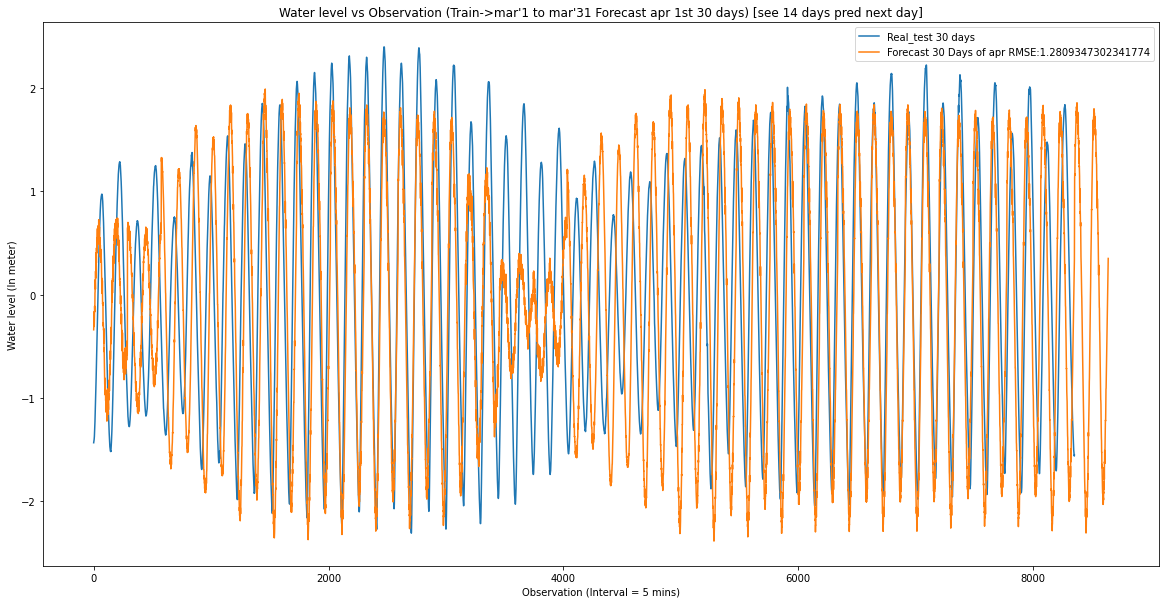

In [ ]:
#For 30 days 
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Tide work/CTG/lb_14_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')
forecast_30days=[]
#test = train_X[-1]
test = test_X[0]
a = test_X[0].tolist()
shift = 0

for i in range(30):
  train = a[0+shift: (look_back*see_days)+shift]
  train = np.asarray(train)
  train = numpy.reshape(train, (1, trainX.shape[1], 1))
  test = model1.predict(train)
  var1 = test[0]
  var1 = var1.tolist()
  var2 = [[i] for i in var1]
  test = numpy.reshape(test, (trainY.shape[1]))
  forecast_30days.append(test)
  # print(a)
  a = a + var2
  # print(a)
  shift = shift + look_back

forecast_30days = numpy.array(forecast_30days)
forcast30Score = math.sqrt(mean_squared_error(testY[:30,0], forecast_30days[:,0]))

#testY_c = np.resize(testY,(len(dataset_test[:2016]),1))
testPredict_c = np.resize(forecast_30days,(look_back*30,1))

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testPredict_c)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[0:len(testPredict_c), :] = testPredict_c

fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(dataset_test[:2016], label = "Real_test 30 days ")
ax.plot(testY_c[:8352], label = "Real_test 30 days ")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(testPredictPlot, label = "Forecast 30 Days of apr RMSE:"+str(forcast30Score))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 Forecast apr 1st 30 days) [see "+str(see_days)+" days pred next day]")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_14_tr_1mon/30days/30 Water level vs Observation (Train - mar'1 to mar'31 Forecast apr 1st 30 days) see "+str(see_days)+" days pred next day.png")

# see 7 days & predict & forecast next 15 days [Train 1 month]

## imports

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import keras
import numpy as np
from itertools import chain
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

## data preparation

In [ ]:
dataframe = pandas.read_csv("/content/drive/MyDrive/Tide work/CTG/dataset/CTG_2020.csv",
                            header=None, delimiter = "\t", engine="python")

dataframe = dataframe.drop(dataframe.index[0])
dataframe = dataframe.reset_index(drop=True)

In [ ]:
see_days = 7

## train data

In [ ]:
start_range_train = 0
end_range_train = 0

for x in range(len(dataframe)):
  if((dataframe[0][x] == '3/1/2020') & (dataframe[1][x] == '0:00')):
    start_range_train = x
  if((dataframe[0][x] == '3/31/2020') & (dataframe[1][x] == '23:55')):
    end_range_train = x


train_data = dataframe.iloc[start_range_train:(end_range_train+1)]
train_data = train_data.drop(columns=[0,1])

# train_data = train_data.values
# train_data = train_data.astype('float32')

In [ ]:
train_data = train_data.T
train_data.shape

(1, 8928)

In [ ]:
train_data = np.asarray(train_data)
train_data = train_data.tolist()
train_data = list(chain.from_iterable(train_data))

## test data

In [ ]:
start_range_test = 0
end_range_test = 0

for x in range(len(dataframe)):
  if((dataframe[0][x] == '3/25/2020') & (dataframe[1][x] == '0:00')):
    start_range_test = x
  if((dataframe[0][x] == '4/30/2020') & (dataframe[1][x] == '23:55')):
    end_range_test = x


test_data = dataframe.iloc[start_range_test:(end_range_test+1)]
test_data = test_data.drop(columns=[0,1])

# test_data = test_data.values
# test_data = test_data.astype('float32')

In [ ]:
test_data = test_data.T
test_data.shape

(1, 10656)

In [ ]:
test_data = np.asarray(test_data)
test_data = test_data.tolist()
test_data = list(chain.from_iterable(test_data))

## X, y for train & test

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
  dataX, dataY = [], []
  for i in range(0,(len(dataset)-look_back*see_days),look_back):
    a = dataset[i:(i + look_back*see_days)]
    dataX.append(a)
    b = dataset[(i + look_back*see_days):(i + look_back*(see_days+1))]
    dataY.append(b)
  return dataX, dataY

In [ ]:
# reshape into X=t and Y=t+1
look_back = 288
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [ ]:
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)

testX = np.asarray(testX)
testY = np.asarray(testY)

In [ ]:
trainX = trainX.astype(np.float)
trainY = trainY.astype(np.float)

testX = testX.astype(np.float)
testY = testY.astype(np.float)

In [ ]:
# reshape input to be [samples, time steps, features]
# train_X = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# test_X = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

train_X = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test_X = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
train_X.shape

(24, 2016, 1)

## model train

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(512, input_shape=(look_back*see_days, 1)))
model.add(Dense(look_back))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, trainY, epochs=100, batch_size=1, verbose=2) #, callbacks=[es]

Epoch 1/100
24/24 - 4s - loss: 1.2509
Epoch 2/100
24/24 - 3s - loss: 1.0183
Epoch 3/100
24/24 - 3s - loss: 0.9817
Epoch 4/100
24/24 - 3s - loss: 0.8500
Epoch 5/100
24/24 - 3s - loss: 0.5184
Epoch 6/100
24/24 - 3s - loss: 0.8382
Epoch 7/100
24/24 - 3s - loss: 0.9044
Epoch 8/100
24/24 - 3s - loss: 0.6542
Epoch 9/100
24/24 - 3s - loss: 0.5578
Epoch 10/100
24/24 - 3s - loss: 0.4251
Epoch 11/100
24/24 - 3s - loss: 0.3251
Epoch 12/100
24/24 - 3s - loss: 0.4134
Epoch 13/100
24/24 - 3s - loss: 0.4755
Epoch 14/100
24/24 - 3s - loss: 0.3454
Epoch 15/100
24/24 - 3s - loss: 0.1402
Epoch 16/100
24/24 - 3s - loss: 0.1856
Epoch 17/100
24/24 - 3s - loss: 0.3909
Epoch 18/100
24/24 - 3s - loss: 0.2362
Epoch 19/100
24/24 - 3s - loss: 0.2082
Epoch 20/100
24/24 - 3s - loss: 0.1312
Epoch 21/100
24/24 - 3s - loss: 0.0612
Epoch 22/100
24/24 - 3s - loss: 0.0529
Epoch 23/100
24/24 - 3s - loss: 0.0690
Epoch 24/100
24/24 - 3s - loss: 0.1268
Epoch 25/100
24/24 - 3s - loss: 0.1097
Epoch 26/100
24/24 - 3s - loss: 0.

## make prediction and save model

In [ ]:
# make predictions
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

Train Score: 0.09228 RMSE
Test Score: 0.10415 RMSE


In [ ]:
model.save('/content/drive/MyDrive/Tide work/CTG/lb_7_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')

In [ ]:
# from keras.models import load_model
# model1 = load_model('/content/drive/MyDrive/Tide work/CTG/lb_7_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')
# trainPredict = model1.predict(train_X)
# testPredict = model1.predict(test_X)

# trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

## train & test predict + plot

In [ ]:
trainY_c = np.resize(trainY,(len(train_data)-look_back*see_days,1))
trainPredict_c = np.resize(trainPredict,(len(train_data)-look_back*see_days,1))
testY_c = np.resize(testY,(len(test_data)-look_back*see_days,1))
testPredict_c = np.resize(testPredict,(len(test_data)-look_back*see_days,1))

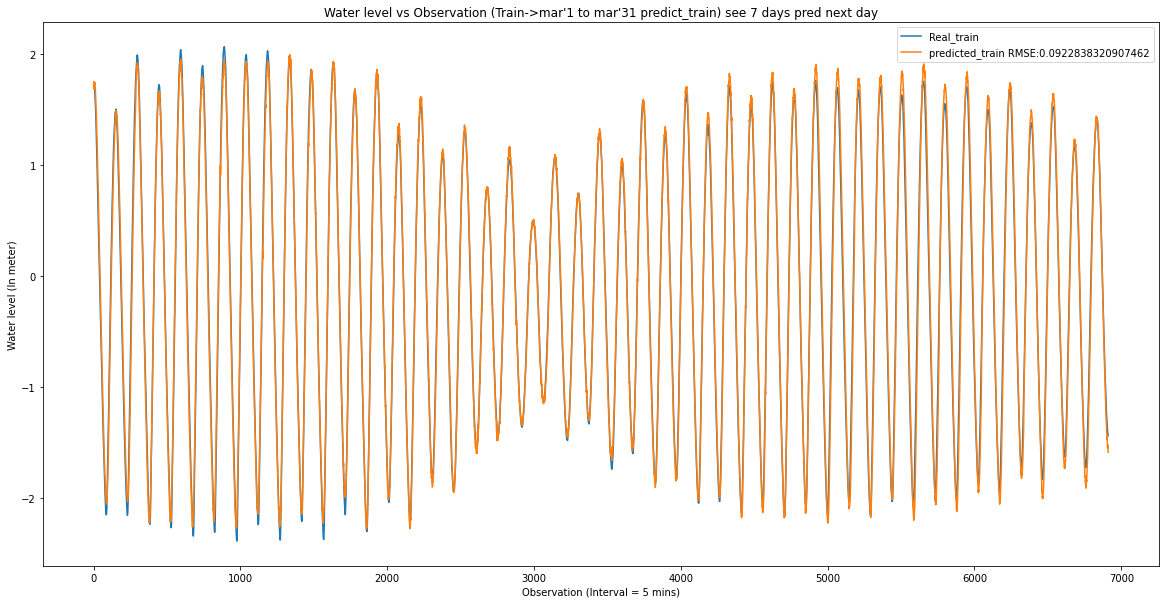

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(trainPredict_c)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[0:len(trainPredict_c), :] = trainPredict_c

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(trainY_c, label = "Real_train")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(trainPredictPlot, label = "predicted_train RMSE:"+str(trainScore))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 predict_train) see "+str(see_days)+" days pred next day")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_7_tr_1mon/1 see "+str(see_days)+" days pred next day (train).png")

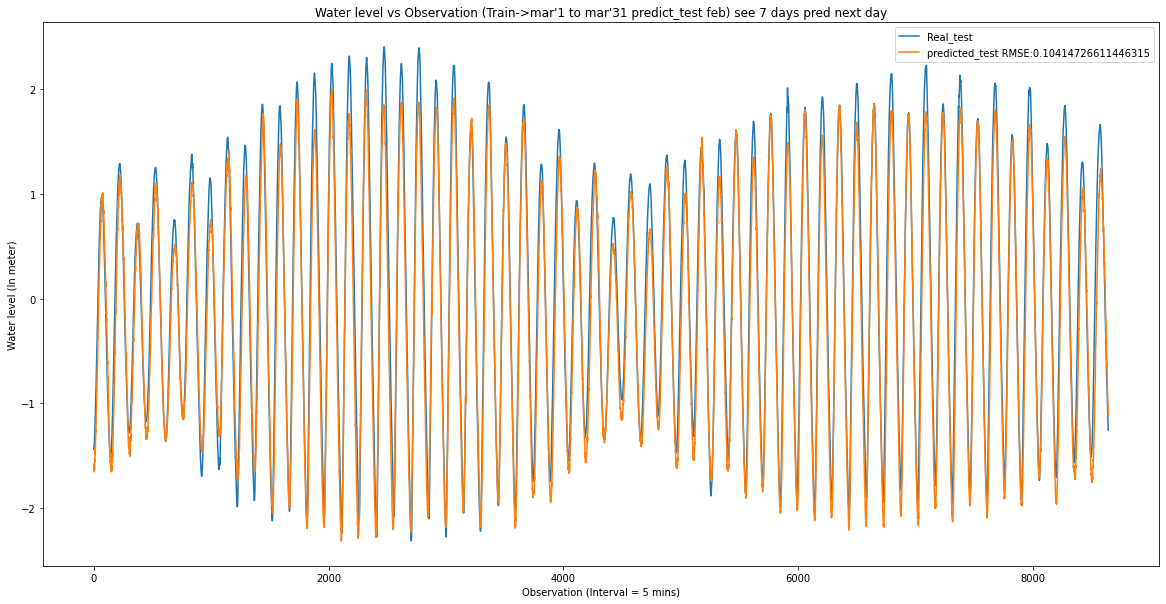

In [ ]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testPredict_c)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[0:len(testPredict_c), :] = testPredict_c
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(testY_c, label = "Real_test")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(testPredictPlot, label = "predicted_test RMSE:"+str(testScore))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 predict_test feb) see "+str(see_days)+" days pred next day")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_7_tr_1mon/1 see "+str(see_days)+" days pred next day (test).png")

## forecast 15 days

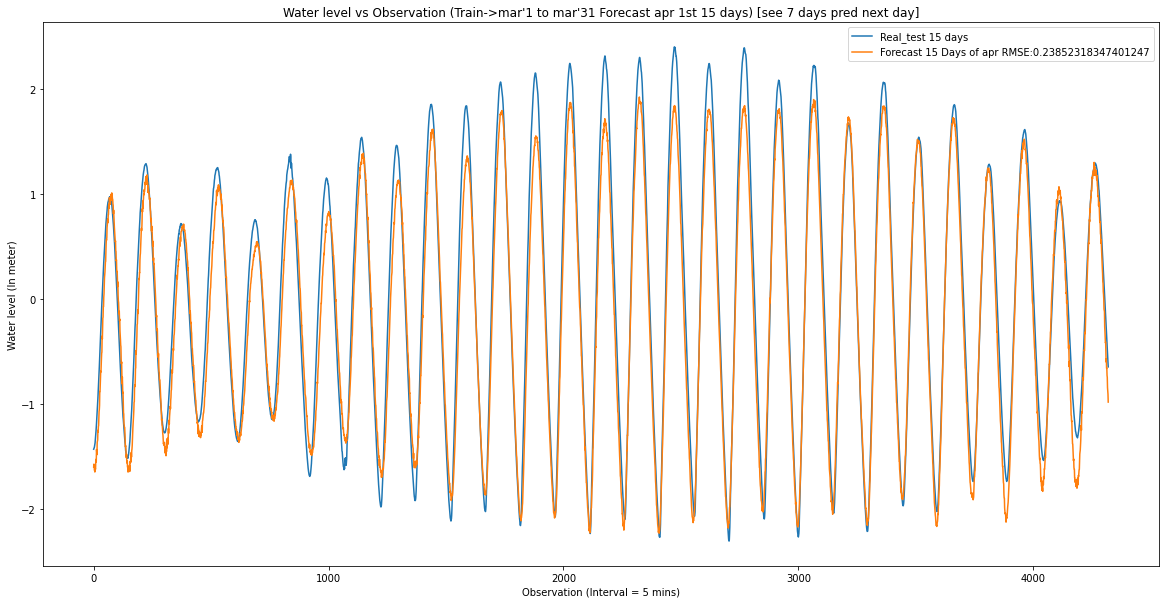

In [ ]:
#For 15 days 
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Tide work/CTG/lb_7_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')
forecast_15days=[]
#test = train_X[-1]
test = test_X[0]
a = test_X[0].tolist()
shift = 0

for i in range(15):
  train = a[0+shift: (look_back*see_days)+shift]
  train = np.asarray(train)
  train = numpy.reshape(train, (1, trainX.shape[1], 1))
  test = model1.predict(train)
  var1 = test[0]
  var1 = var1.tolist()
  var2 = [[i] for i in var1]
  test = numpy.reshape(test, (trainY.shape[1]))
  forecast_15days.append(test)
  # print(a)
  a = a + var2
  # print(a)
  shift = shift + look_back

forecast_15days = numpy.array(forecast_15days)
forcast15Score = math.sqrt(mean_squared_error(testY[:15,0], forecast_15days[:,0]))

#testY_c = np.resize(testY,(len(dataset_test[:2016]),1))
testPredict_c = np.resize(forecast_15days,(look_back*15,1))

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testPredict_c)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[0:len(testPredict_c), :] = testPredict_c

fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(dataset_test[:2016], label = "Real_test 15 days ")
ax.plot(testY_c[:4320], label = "Real_test 15 days ")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(testPredictPlot, label = "Forecast 15 Days of apr RMSE:"+str(forcast15Score))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 Forecast apr 1st 15 days) [see "+str(see_days)+" days pred next day]")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_7_tr_1mon/15days/15 Water level vs Observation (Train - mar'1 to mar'31 Forecast apr 1st 15 days) see "+str(see_days)+" days pred next day.png")

## forecast 29 days

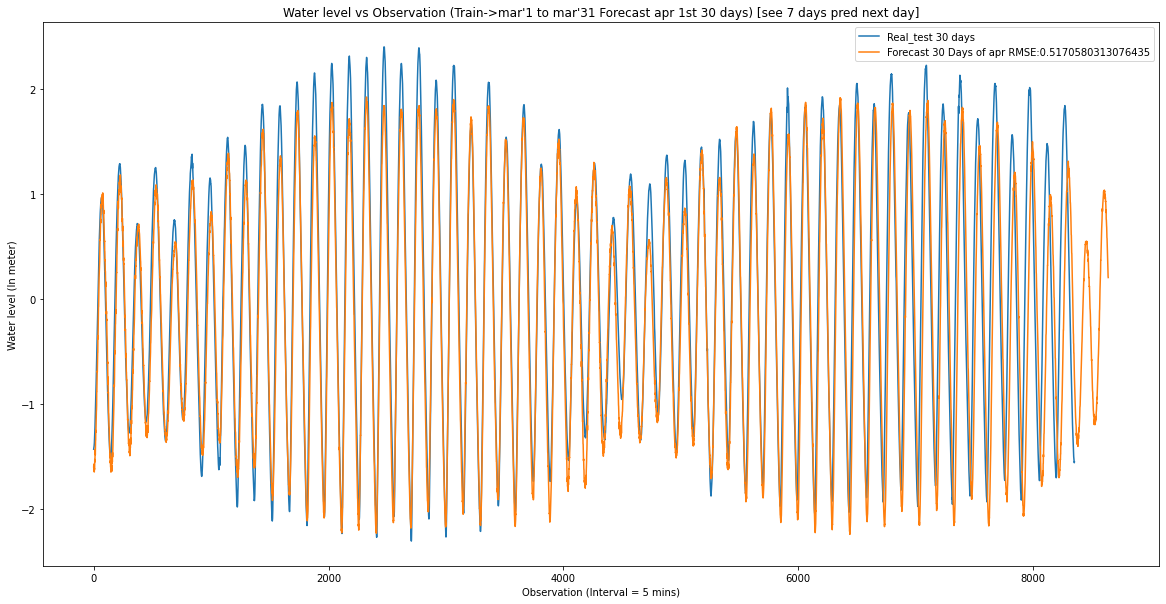

In [ ]:
#For 30 days 
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Tide work/CTG/lb_7_tr_1mon/see_'+str(see_days)+'_days_pred_1_day_apr.h5')
forecast_30days=[]
#test = train_X[-1]
test = test_X[0]
a = test_X[0].tolist()
shift = 0

for i in range(30):
  train = a[0+shift: (look_back*see_days)+shift]
  train = np.asarray(train)
  train = numpy.reshape(train, (1, trainX.shape[1], 1))
  test = model1.predict(train)
  var1 = test[0]
  var1 = var1.tolist()
  var2 = [[i] for i in var1]
  test = numpy.reshape(test, (trainY.shape[1]))
  forecast_30days.append(test)
  # print(a)
  a = a + var2
  # print(a)
  shift = shift + look_back

forecast_30days = numpy.array(forecast_30days)
forcast30Score = math.sqrt(mean_squared_error(testY[:30,0], forecast_30days[:,0]))

#testY_c = np.resize(testY,(len(dataset_test[:2016]),1))
testPredict_c = np.resize(forecast_30days,(look_back*30,1))

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(testPredict_c)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[0:len(testPredict_c), :] = testPredict_c

fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(dataset_test[:2016], label = "Real_test 30 days ")
ax.plot(testY_c[:8352], label = "Real_test 30 days ")
ax.set_xlabel("Observation (Interval = 5 mins)")
ax.set_ylabel("Water level (In meter)")
ax.plot(testPredictPlot, label = "Forecast 30 Days of apr RMSE:"+str(forcast30Score))
ax.set_title("Water level vs Observation (Train->mar'1 to mar'31 Forecast apr 1st 30 days) [see "+str(see_days)+" days pred next day]")
leg = ax.legend();
fig.savefig("/content/drive/MyDrive/Tide work/CTG/lb_7_tr_1mon/30days/30 Water level vs Observation (Train - mar'1 to mar'31 Forecast apr 1st 30 days) see "+str(see_days)+" days pred next day.png")